In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import lightning

In [193]:
class EMA_linear(nn.Module):
    """EMA_linear

    Exponential Moving Average Linear Layer

    This layer is used to store a non-trainable version of the weights and biases of
    another layer, so that it can act as a target layer for a twin layer that is actually
    being optimized. The weights and biases of this layer are updated with an exponential
    moving average upon calling the `update` method. The update is performed every `steps_to_update`
    """

    def __init__(
        self,
        in_features,
        out_features,
        alpha=0.999,
        negative_slope=1e-3,
        steps_to_update=1,
    ):
        """__init__ EMA_linear

        Parameters
        ----------
        in_features : int
            Number of input features
        out_features : int
            int
        alpha : float, optional
            EMA smoothing coefficient, by default 0.999
        negative_slope : int, optional
            leaky_ReLU negative slope used to initialize the weights, by default 1e-3
        steps_to_update : int, optional
            steps before an actual update is performed, by default 1
        """
        super(EMA_linear, self).__init__()

        assert 0.0 <= alpha <= 1.0, f"Invalid alpha: {alpha}"
        assert steps_to_update > 0, f"Invalid steps_to_update: {steps_to_update}"

        self.alpha = alpha
        self.in_features = in_features
        self.out_features = out_features
        self.steps_to_update = steps_to_update
        self._step = 0
        self.negative_slope = negative_slope
        self.register_buffer("weight", torch.zeros(out_features, in_features))
        self.register_buffer("bias", torch.zeros(out_features))
        self.reset_parameters()

    def reset_parameters(self):
        nn.init.kaiming_normal_(self.weight, a=self.negative_slope)
        nn.init.constant_(self.bias, 0)

    def set_parameters(self, weight, bias):
        """set_parameters

        Parameters
        ----------
        weight : torch.Tensor
            weight tensor
        bias : torch.Tensor
            bias tensor
        """
        with torch.no_grad():
            self.weight.copy_(weight)
            self.bias.copy_(bias)

    def forward(self, input):
        """forward

        MX + b, that's all

        Parameters
        ----------
        input : torch.Tensor
            input tensor

        Returns
        -------
        torch.Tensor
            output tensor
        """
        return F.linear(input, self.weight, self.bias)

    def update(self, weight, bias):
        """update

        Parameters
        ----------
        weight : torch.Parameter
            weight tensor
        bias : torch.Parameter
            bias tensor
        """

        self._step += 1

        if self._step % self.steps_to_update != 0:
            return

        with torch.no_grad():
            self.weight.copy_(self.alpha * self.weight + (1 - self.alpha) * weight)
            self.bias.copy_(self.alpha * self.bias + (1 - self.alpha) * bias)
        self._step = 0

    def extra_repr(self):
        return "in_features={}, out_features={}, alpha={}".format(
            self.in_features, self.out_features, self.alpha
        )

In [ ]:
class AnomalyDataset(torch.utils.data.Dataset):

    def __init__(self, N, D):
        super(AnomalyDataset, self).__init__()
        self.normal_data = torch.randn(N - N // 10, D) - 2.5 * torch.randn(D)
        self.anomaly_data = torch.randn(N // 10, D) + 5.0 * torch.randn(D)

        # introduce correlation between the two dimensions
        for i in range(1, D):
            for j in range(i):
                self.anomaly_data[:, i] += self.anomaly_data[:, j] * torch.randn(
                    1
                ) + torch.sin(self.anomaly_data[:, j])
                self.normal_data[:, i] += self.normal_data[:, j] * torch.randn(
                    1
                ) + torch.cos(self.normal_data[:, j])

        self.total_data = torch.cat([self.normal_data, self.anomaly_data], dim=0)
        self.labels = torch.cat([torch.zeros(N - N // 10), torch.ones(N // 10)], dim=0)

    def __len__(self):
        return len(self.total_data)

    def __getitem__(self, idx):
        return self.total_data[idx], self.labels[idx]


class AnomalyModule(lightning.LightningDataModule):

    def __init__(self, N, D, batch_size=32):
        super(AnomalyModule, self).__init__()
        self.data = AnomalyDataset(N, D)
        self.train_data, self.val_data = torch.utils.data.random_split(
            self.data, [int(0.8 * N), N - int(0.8 * N)]
        )
        self.batch_size = batch_size

    def setup(self, stage=None):
        pass

    def train_dataloader(self):
        return torch.utils.data.DataLoader(
            self.train_data, batch_size=self.batch_size, shuffle=True
        )

    def val_dataloader(self):
        return torch.utils.data.DataLoader(
            self.val_data, batch_size=self.batch_size, shuffle=False
        )

    def __len__(self):
        return len(self.data)

In [228]:
from matplotlib import pyplot as plt


def contrastive_loss(y_hat_1, y_hat_2, temperature=0.1):

    y_hat_1 = F.normalize(y_hat_1, dim=0)
    y_hat_2 = F.normalize(y_hat_2, dim=0)

    return 2 - 2 * (y_hat_1 * y_hat_2).sum(dim=0).mean()


class SiameseProjectionHead(lightning.LightningModule):

    def __init__(self, in_features, out_features):
        super(SiameseProjectionHead, self).__init__()
        self.head_1_1 = nn.Linear(in_features, out_features)
        self.head_1_2 = nn.Linear(out_features, out_features)
        self.head_2_1 = EMA_linear(in_features, out_features, steps_to_update=2)
        self.head_2_2 = EMA_linear(out_features, out_features, steps_to_update=2)

        self.similarities = []

        self.apply(self._init_weights)

        # self.head_2_1.set_parameters(self.head_1_1.weight, self.head_1_1.bias)
        # self.head_2_2.set_parameters(self.head_1_2.weight, self.head_1_2.bias)

    def _init_weights(self, m):

        if isinstance(m, nn.Linear):
            nn.init.kaiming_normal_(m.weight, a=1e-3)
            nn.init.constant_(m.bias, 0)

    def forward(self, x):

        y_hat_1 = self.head_1_2(F.leaky_relu(self.head_1_1(x), negative_slope=1e-3))
        y_hat_2 = self.head_2_2(F.leaky_relu(self.head_2_1(x), negative_slope=1e-3))

        return y_hat_1, y_hat_2

    def training_step(self, batch, batch_idx):

        x, _ = batch
        y_hat_1, y_hat_2 = self(x)

        loss = contrastive_loss(y_hat_1, y_hat_2)

        self.head_2_1.update(self.head_1_1.weight, self.head_1_1.bias)
        self.head_2_2.update(self.head_1_2.weight, self.head_1_2.bias)

        if batch_idx % 100 == 0:
            # log cosine similarity of weights
            with torch.no_grad():
                self.similarities.append(
                    F.cosine_similarity(self.head_1_1.weight, self.head_2_1.weight)
                    .mean()
                    .item()
                )

        return loss

    def configure_optimizers(self):
        return torch.optim.AdamW(self.parameters(), lr=1e-5)

    def anomaly_score(self, x):

        y_hat_1, y_hat_2 = self(x)
        return contrastive_loss(y_hat_1, y_hat_2)

In [229]:
data = AnomalyModule(5000, 128, batch_size=128)

In [232]:
net = SiameseProjectionHead(128, 64)

trainer = lightning.Trainer(max_epochs=100)

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


In [233]:
trainer.fit(net, data)

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name     | Type       | Params
----------------------------------------
0 | head_1_1 | Linear     | 8.3 K 
1 | head_1_2 | Linear     | 4.2 K 
2 | head_2_1 | EMA_linear | 0     
3 | head_2_2 | EMA_linear | 0     
----------------------------------------
12.4 K    Trainable params
0         Non-trainable params
12.4 K    Total params
0.050     Total estimated model params size (MB)


Training: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=100` reached.


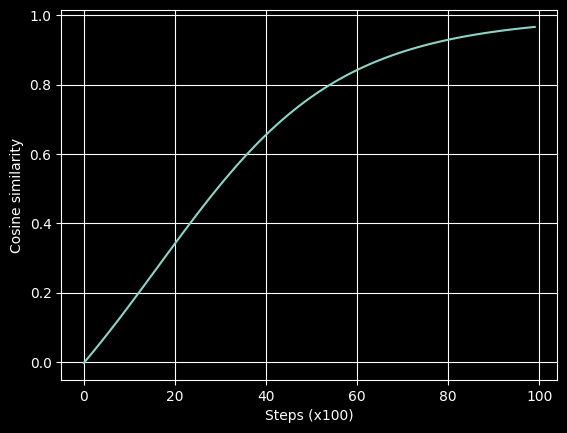

In [238]:
plt.plot(net.similarities, label="Cosine similarity of weights between heads")
plt.xlabel("Steps (x100)")
plt.ylabel("Cosine similarity")

plt.grid()

plt.show()

In [235]:
net.head_2_1.weight

tensor([[ 0.0152,  0.0601,  0.0390,  ...,  0.1106, -0.1470, -0.0648],
        [ 0.0235, -0.0084, -0.0743,  ...,  0.1758,  0.1622,  0.1090],
        [-0.0309, -0.0267,  0.0058,  ...,  0.0113, -0.0673, -0.0841],
        ...,
        [ 0.0373, -0.2460,  0.0477,  ..., -0.1265,  0.0965,  0.0238],
        [-0.0761,  0.1184, -0.0040,  ...,  0.0410, -0.1313,  0.0612],
        [ 0.0417,  0.0181, -0.0737,  ..., -0.1700, -0.0005,  0.0184]])

In [236]:
net.head_1_1.weight

Parameter containing:
tensor([[ 0.0158,  0.0927,  0.0358,  ...,  0.1278, -0.1246, -0.0654],
        [ 0.0090, -0.0662, -0.0603,  ...,  0.1438,  0.1862,  0.0725],
        [-0.0677, -0.0098,  0.0134,  ...,  0.0088, -0.0573, -0.0782],
        ...,
        [ 0.0391, -0.2793,  0.0162,  ..., -0.1219,  0.1442,  0.0538],
        [-0.0944,  0.1313,  0.0364,  ...,  0.0551, -0.1656,  0.0890],
        [ 0.0621,  0.0341, -0.0559,  ..., -0.2171, -0.0171,  0.0220]],
       requires_grad=True)

In [237]:
F.cosine_similarity(net.head_1_1.weight, net.head_2_1.weight).mean()

tensor(0.9676, grad_fn=<MeanBackward0>)

## Losses

In [239]:
# We set \sigma = 1 based on the cited papers 18 and 19 in ReConPatch
class ContextualSimilarity(nn.Module):
    def __init__(self, k=5, alpha=0.5):
        super(ContextualSimilarity, self).__init__()
        self.k = k
        self.alpha = alpha

    def forward(self, z):
        distances = torch.cdist(z, z)
        topk_dist = -torch.topk(-distances, self.k)[0][:, -1]
        filtering = (distances <= topk_dist.unsqueeze(-1)).float()
        similarity = torch.matmul(filtering, filtering.transpose(0, 1)) / torch.sum(
            filtering, dim=-1, keepdim=True
        )
        R = filtering * filtering.transpose(0, 1)
        similarity = torch.matmul(similarity, R.transpose(0, 1)) / torch.sum(
            R, dim=-1, keepdim=True
        )
        return self.alpha * (similarity + similarity.transpose(0, 1))


class PairwiseSimilarity(nn.Module):
    def __init__(self, sigma=1.0):
        super(PairwiseSimilarity, self).__init__()
        self.sigma = sigma

    def forward(self, z):
        return torch.exp(-(torch.cdist(z, z) / self.sigma))


def relaxedContrastiveLoss(w, delta, m):
    return torch.mean(
        w * delta**2 + (1 - w) * torch.max(m - delta, torch.tensor(0.0)) ** 2
    )


class RelaxedContrastiveLoss(nn.Module):
    def __init__(self, margin):
        super(RelaxedContrastiveLoss, self).__init__()
        self.margin = margin

    def forward(self, w, delta):
        return torch.mean(
            w * delta**2
            + (1 - w) * torch.max(self.margin - delta, torch.tensor(0.0)) ** 2
        )

## Models

In [240]:
class ReConPatch(lightning.LightningModule):

    def __init__(
        self, input_dim=1536, emb_dim=512, proj_dim=1024, alpha=0.5, margin=0.1
    ):

        super(ReConPatch, self).__init__()

        self.emb_dim = emb_dim
        self.proj_dim = proj_dim
        self.alpha = alpha
        self.margin = margin

        self.fmap_buf = []
        self.memory_bank = []

        self.wr_model = torch.hub.load(
            "pytorch/vision:v0.13.0", "wide_resnet50_2", pretrained=True
        ).eval()

        # freeze the model
        for param in self.wr_model.parameters():
            param.requires_grad = False

        def hook(module, input, output):
            self.fmap_buf.append(output)

        self.wr_model.layer2.register_forward_hook(hook)
        self.wr_model.layer3.register_forward_hook(hook)

        # Online head

        self.repr_layer = nn.Linear(input_dim, emb_dim)
        self.proj_layer = nn.Linear(emb_dim, proj_dim)

        # Target head

        self.target_repr_layer = EMA_linear(input_dim, emb_dim, steps_to_update=1)
        self.target_proj_layer = EMA_linear(emb_dim, proj_dim, steps_to_update=1)

        # Filters

        self.blur = nn.AvgPool2d(kernel_size=3, stride=1)

        self.activ = nn.LeakyReLU(negative_slope=1e-3)

        self.apply(self._init_weights)

        # step to have similar weights
        self.target_proj_layer.update(self.proj_layer.weight, self.proj_layer.bias)
        self.target_repr_layer.update(self.repr_layer.weight, self.repr_layer.bias)

        self.pairwise_sim = PairwiseSimilarity()
        self.contextual_sim = ContextualSimilarity()
        self.criterion = RelaxedContrastiveLoss(self.margin)

    def forward(self, X):
        """forward

        Parameters
        ----------
        X : torch.Tensor
            dimensions B x C x H x W
        """

        # empty out fmap buffer
        self.fmap_buf = []

        # trigger forward pass (and hook)
        _ = self.wr_model(X)

        dims = (
            int(max([map.shape[-2] for map in self.fmap_buf])),
            int(max([map.shape[-1] for map in self.fmap_buf])),
        )

        pool = nn.AdaptiveAvgPool2d(dims)
        preproc = lambda t: pool(self.blur(t))

        feat_stacks = torch.cat([preproc(map) for map in self.fmap_buf], dim=1)
        feat_stack_reshape = feat_stacks.reshape(feat_stacks.shape[1], -1).T

        # Online head

        repr = self.activ(self.repr_layer(feat_stack_reshape))
        proj = self.proj_layer(repr)

        p_sim = self.pairwise_sim(proj)
        c_sim = self.contextual_sim(proj)

        w = self.alpha * p_sim + (1 - self.alpha) * c_sim
        # Target head

        target_repr = self.target_repr_layer(feat_stack_reshape)
        target_proj = self.target_proj_layer(target_repr)

        pairwise = torch.cdist(target_proj, target_proj)

        EPS = 1e-9

        d = torch.sqrt(pairwise + EPS)
        delta = d / d.mean()

        return w, delta

    def training_step(self, batch, batch_idx):
        x, y = batch
        w, delta = self(x)

        loss = self.criterion(w, delta)
        self.log("train/loss", loss)
        return loss

    def validation_step(self, batch, batch_idx):
        x, y = batch
        w, delta = self(x)

        loss = self.criterion(w, delta)
        self.log("val/loss", loss)
        return loss

    def test_step(self, batch, batch_idx):
        x, y = batch
        w, delta = self(x)

        loss = self.criterion(w, delta)
        self.log("test/loss", loss)
        return loss

    def configure_optimizers(self):
        opt = torch.optim.AdamP(
            self.parameters(), lr=1e-6, betas=(0.9, 0.999), weight_decay=1e-2
        )
        sched = torch.optim.lr_scheduler.CosineAnnealingWarmRestarts(
            opt, T_0=10, T_mult=2
        )

        return [opt], [sched]

    def save_bank(self, path):
        torch.save(self.memory_bank, path)

    def load_bank(self, path):
        self.memory_bank = torch.load(path)

    def _init_weights(self, m):
        if isinstance(m, nn.Linear):
            nn.init.kaiming_normal_(m.weight, a=1e-3)
            nn.init.constant_(m.bias, 0)
        elif isinstance(m, EMA_linear):
            m.reset_parameters()

    def on_after_backward(self):
        # update target layers
        self.target_proj_layer.update(self.proj_layer.weight, self.proj_layer.bias)
        self.target_repr_layer.update(self.repr_layer.weight, self.repr_layer.bias)